<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/astrostats_sdss_2pcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will guide you through a realistic analysis of galaxy survey data.
We will download real data and then measure its 2-point correlation function.

In [1]:
import scipy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10.0, 10.0]})

### Download SDSS eBOSS DR12 CMASS data and random catalogs
search in https://data.sdss.org/sas/ for other catalogues if you want to try a different target eg, ELG, QSO - or even newer eBOSS data!

In [65]:
!wget https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz
!wget https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz

--2024-04-14 06:20:27--  https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1172229517 (1.1G) [application/octet-stream]
Saving to: ‘random0_DR12v5_CMASS_South.fits.gz.1’

random0_DR12v5_CMAS 100%[===================>]   1.09G  72.1MB/s    in 29s     

2024-04-14 06:20:56 (38.8 MB/s) - ‘random0_DR12v5_CMASS_South.fits.gz.1’ saved [1172229517/1172229517]

--2024-04-14 06:20:56--  https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51580500 (49M) [application/octet-stream]
Saving to: ‘galaxy_DR12v5_CMASS_South.fits.gz.1’

galaxy_DR12v5_CMASS 100%[===================>]  49

### Extract relavent columns from the fits file
Angular positions (RA, dec), redshift (z) and weights

In [69]:
hdul = fits.open('galaxy_DR12v5_CMASS_South.fits.gz')

ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wtot=hdul[1].data['WEIGHT_SYSTOT']
wcp=hdul[1].data['WEIGHT_CP']
wnoz=hdul[1].data['WEIGHT_NOZ']
wfkp=hdul[1].data['WEIGHT_FKP']
wgal=wtot*wfkp*(wcp+wnoz-1.0) #Eq 2 from https://arxiv.org/pdf/1607.03154.pdf


### Plot the redshift distribution

mean redshift of the galaxies : 0.5426714


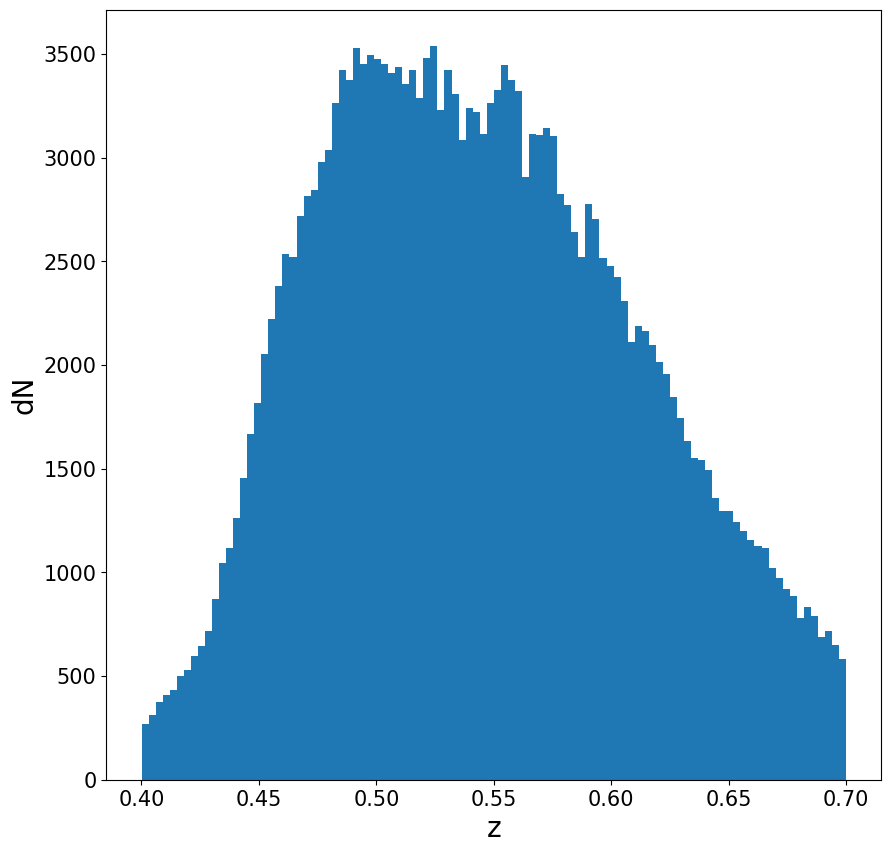

In [70]:
ind=np.where((z>0.4) & (z<0.7)) #cut the redshift range
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the galaxies :",np.mean(z))

Text(0, 0.5, 'dec')

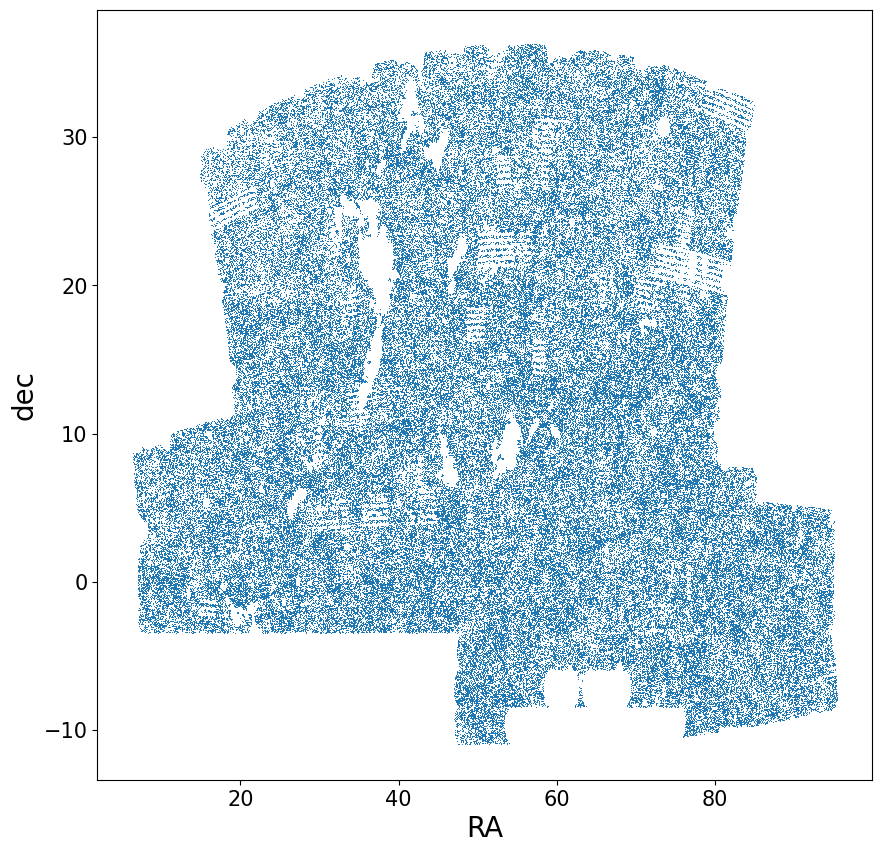

In [71]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra+50,360),dec,',')
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

## Use astropy to convert from angle and redshift to cartesean comoving x,y,z positions

In [72]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord

ind=np.where((z>0.4) & (z<0.7))
cosmo=FlatLambdaCDM(Om0=0.30,H0=100) # sets the cosmological model working in units Mpc/h with Ho=100
dist=cosmo.comoving_distance(z[ind]).value  # convert redshift to distance

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc) # convert to x,y,z
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z))

### Load the Random Catalogue and repeat the same proceedure

In [73]:
hdul = fits.open('random0_DR12v5_CMASS_South.fits.gz')

ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wrand=hdul[1].data['WEIGHT_FKP']

mean redshift of the randoms : 0.5433296495801546


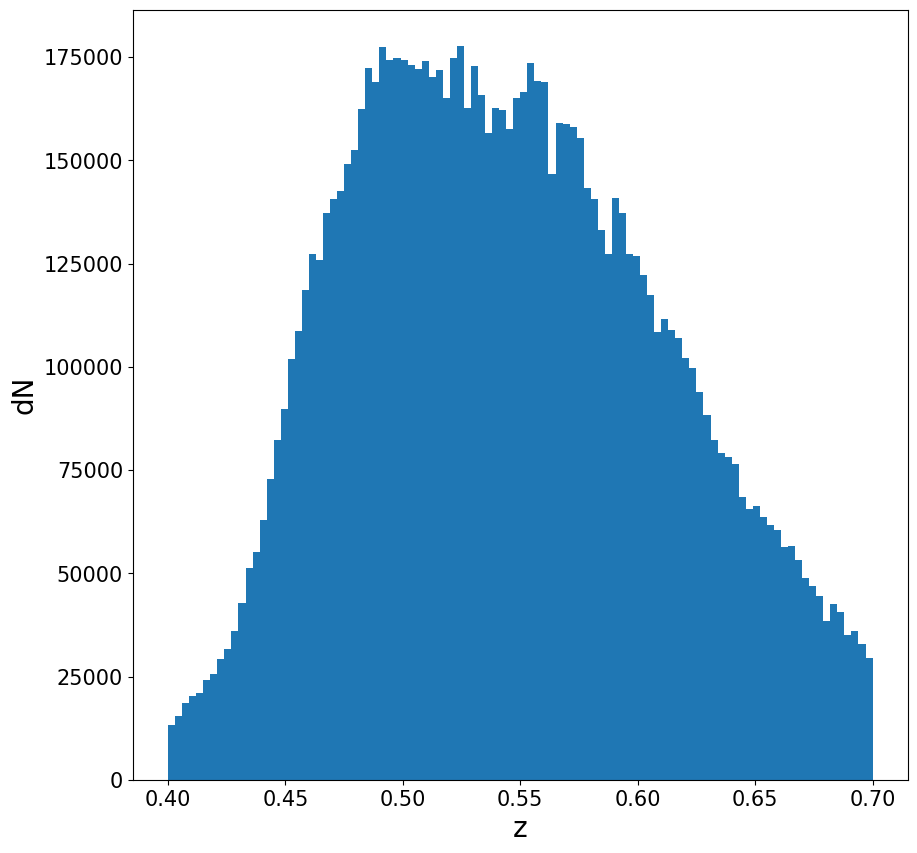

In [74]:
ind=np.where((z>0.4) & (z<0.7))
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the randoms :",np.mean(z))

Plotting the random point angular positions we see that they look almostly exactly like the galaxies as they should

Text(0, 0.5, 'dec')

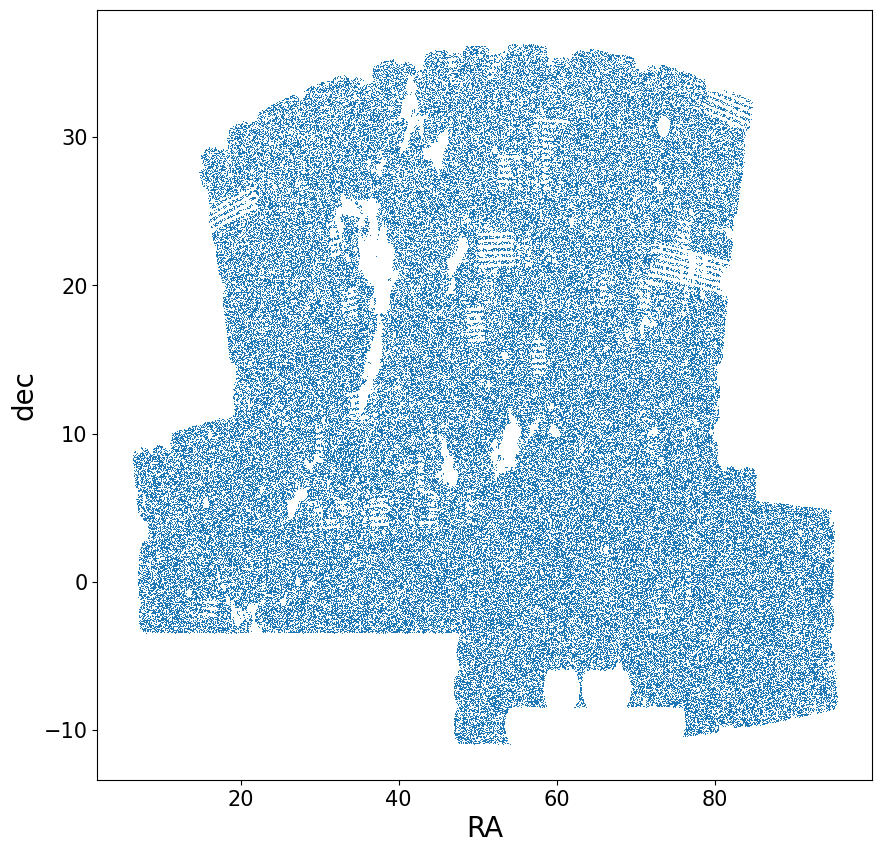

In [75]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra[::50]+50,360),dec[::50],',') # plot a random sample 1/50
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

In [78]:
dist=cosmo.comoving_distance(z[ind]).value

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc)
rand=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z))
rand = rand[::50,:] # save a subsample of the data (1/50)

In [89]:
print("number of Galaxies:", np.shape(data)[0])
print("number of Randoms:", np.shape(rand)[0])

#lets down-sample by 1/30 to make this faster
data_s = data[::30,:]
rand_s= rand[::30,:]

print("number of downsampled Galaxies:", np.shape(data_s)[0])
print("number of downsampled Randoms:", np.shape(rand_s)[0])

number of Galaxies: 213205
number of Randoms: 214868
number of downsampled Galaxies: 7107
number of downsampled Randoms: 7163


# Measure the 2-point correlation function


1.   Count the number of pairs of galaxies (DD) where 40<r<50 Mpc
2.   Count the number of pairs of randoms (RR) where 40<r<50 Mpc
3.   Compute the simple statistic $\xi=\frac{DD}{RR}-1$
4.   Report TWO things: the xi value and the time it took. [0.0389,~8min]

In [99]:
import time #for timing
from tqdm import tqdm #progress bar

start= time.time()

for i in tqdm(range(100)): # this is how you use the progress bar
  np.random.rand((2000000))

end= time.time()

print("\n this is how you time something:",end-start)

100%|██████████| 100/100 [00:02<00:00, 41.46it/s]


 this is how you time something: 2.4321069717407227
